# Large Capacity Auditory Memories for Vocal Communication in Zebra Finches

In [2]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "..", "code"))

import datetime

# External dependencies
import wavio
import soundsig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels.formula.api as smf
from soundsig.sound import spectrogram, plot_spectrogram

# Modules from this repository
from load_data import load_data, load_stimulus
from plotting import color_by_reward, plot_data, set_oddsratio_yticks
from stats import false_discovery, get_odds_ratio_matrix, fisher_exact, jackknife

%load_ext autoreload
%autoreload 2

In [3]:
df = load_data()

In [4]:
df[df["Condition"] == "MonthLater"].Subject.unique()

array(['GreBla5671F', 'GreBla7410M'], dtype=object)

# Describing the song learning ladder

## Figure 1C. Example data from one ladder

In C, individual lines show probability of interruption for individual vocalizers in 20-trial bins (blue: rewarded, red: non-rewarded). Tick marks above the plot indicate interrupted trials and tick marks below the plot indicate non-interrupted trials.

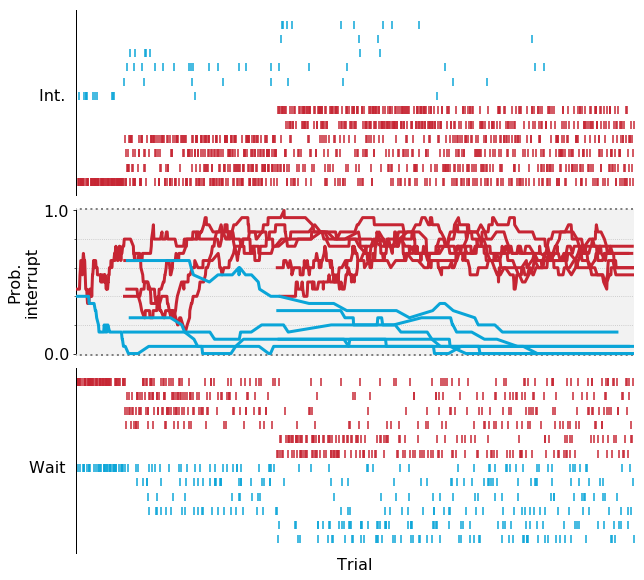

In [5]:
example_subject = "YelRed3010F"
chosen_date_range = (datetime.date(2019, 6, 17), datetime.date(2019, 6, 21))

subject_df = df[df["Subject"] == example_subject]
date_df = subject_df[
    (subject_df.Date >= chosen_date_range[0]) &
    (subject_df.Date <= chosen_date_range[1])
]
fig = plot_data(
    date_df,
    ["Stimulus Class", "Stimulus Vocalizer", "Stimulus Call Type"]
)

plt.show()

fig.savefig("figures/1C_ladder.svg", format="svg", bbox_inches="tight")

plt.close(fig)

## Figure 1D. Song and DC performance summarized (overall)

Data is collected into a table on just evaluation days. This includes each subject's odds ratio comparing their odds of interrupting nonrewarded trials to rewarded trials.

D. Average Odds Ratio for song and DC assessed after learning on Days 4 and 5. Birds perform better on songs (OR=15.5,  95% CI [9.9, 24.4]) than on distance calls (OR=8.4, 95% CI [5.6, 12.9]) (p=0.004, log-transformed paired t-test). Error bars show 2 SEM.

In [53]:
# Creates a table (summary_df) of the overall odds ratio of each subject during the test day for
# the following conditions: SovsSo, DCvsDC, AllvsAll

summary_df_rows = []

for ctx, condition in [
            ("SovsSo_8v8_d2", "None"),
            ("DCvsDC_6v6_d2", "None"),
            ("AllvsAll_28v28", "None"),
            ("AllvsAll_28v28", "MonthLater"),
    ]:
    ctx_df = df[(df["Test Context"] == ctx) & (df["Condition"] == condition)]

    for subject in ctx_df.Subject.unique():
        subject_df = ctx_df[ctx_df.Subject == subject]
        
        rewarded_set = subject_df[subject_df["Stimulus Class"] == "Rewarded"]
        nonrewarded_set = subject_df[subject_df["Stimulus Class"] == "Nonrewarded"]
        
        table = get_odds_ratio_matrix(nonrewarded_set, rewarded_set, "Interrupt")
        odds, interval95, p_value = fisher_exact(table, side="greater")
        se_logor = np.sqrt(
            np.sum(1 / table)
        )

        summary_df_rows.append(
            [
                subject, ctx, condition, odds, interval95[0], interval95[1], np.log(odds), se_logor, p_value, 
            ]
        )
        
summary_df = pd.DataFrame(
    summary_df_rows,
    columns=["Subject", "Test Context", "Condition", "Odds Ratio", "95 CI Lower", "95 CI Upper", "LogOR", "SE(LogOR)", "p-value"]
)

All subjects had odds ratios significantly greater than 1 both when tested on songs (19/19 subjects) and nearly all on when tested on distance calls (18/19 subjects)  (p < 0.0026, one-sided Fisher exact test Bonferroni corrected), indicating that they were successful at this task (Fig. 1D).

In [7]:
# Stats

# 1. Test how many subjects had odds ratios significantly greater than 1, for songs and dcs
n_song = len(summary_df[summary_df["Test Context"] == "SovsSo_8v8_d2"])
alpha = 0.05 / n_song
print("song:", np.sum(summary_df[summary_df["Test Context"] == "SovsSo_8v8_d2"]["p-value"] < alpha), "out of", n_song, "significant")

n_dc = len(summary_df[summary_df["Test Context"] == "DCvsDC_6v6_d2"])
alpha = 0.05 / n_dc
print("dc:", np.sum(summary_df[summary_df["Test Context"] == "DCvsDC_6v6_d2"]["p-value"] < alpha), "out of", n_song, "significant")

song_points = summary_df[summary_df["Test Context"] == "SovsSo_8v8_d2"]["Odds Ratio"]
dc_points = summary_df[summary_df["Test Context"] == "DCvsDC_6v6_d2"]["Odds Ratio"]

# 2. Compute 95% CIs for song and dc across subjects, and do a paired t-test
song_mean = 2 ** np.mean(np.log2(song_points))
dc_mean = 2 ** np.mean(np.log2(dc_points))

song_interval_95 = [
    2 ** (np.mean(np.log2(song_points)) - (2 * np.std(np.log2(song_points)) / np.sqrt(len(song_points)))),
    2 ** (np.mean(np.log2(song_points)) + (2 * np.std(np.log2(song_points)) / np.sqrt(len(song_points))))
]
dc_interval_95 = [
    2 ** (np.mean(np.log2(dc_points)) - (2 * np.std(np.log2(dc_points)) / np.sqrt(len(dc_points)))),
    2 ** (np.mean(np.log2(dc_points)) + (2 * np.std(np.log2(dc_points)) / np.sqrt(len(dc_points))))
]

# Paired t-test
test = scipy.stats.ttest_rel(
    np.log2(song_points),
    np.log2(dc_points),
)


song: 19 out of 19 significant
dc: 18 out of 19 significant


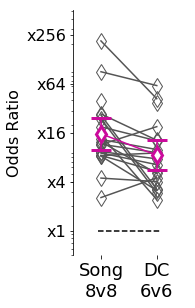



Result of Paired t-test:

Song mean OR: 15.54 [9.88, 24.43]
DC mean OR: 8.44 [5.55, 12.85]
p-value: 0.00376 *




In [8]:
fig = plt.figure(figsize=(2, 4.5))

for subject in summary_df.Subject.unique():
    song_row = summary_df[(summary_df.Subject == subject) & (summary_df["Test Context"] == "SovsSo_8v8_d2")]
    dc_row = summary_df[(summary_df.Subject == subject) & (summary_df["Test Context"] == "DCvsDC_6v6_d2")]

    song_or = song_row.iloc[0]["Odds Ratio"] if len(song_row) else np.nan
    dc_or = dc_row.iloc[0]["Odds Ratio"] if len(dc_row) else np.nan

    plt.plot(
        [0, 1],
        [song_or, dc_or],
        marker="d",
        color="#555555",
        markerfacecolor="none",
        markersize=12,
        zorder=0,
    )

set_oddsratio_yticks(plt.gca(), 9, -1)
plt.xlim(-0.5, 1.5)
plt.xticks([0, 1], ["Song\n8v8", "DC\n6v6"], fontsize=18)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.errorbar(
    [0, 1],
    [song_mean, dc_mean],
    yerr=[
        [song_mean - song_interval_95[0], dc_mean - dc_interval_95[0]],
        [song_interval_95[1] - song_mean, dc_interval_95[1] - dc_mean]
    ],
    marker="d",
    color="#CB0A9C",
    capsize=10,
    markerfacecolor="White",
    markersize=12,
    markeredgewidth=3,
)

plt.show()
fig.savefig("figures/1D_overall_results.svg", format="svg", bbox_inches="tight")
plt.close(fig)


print("""

Result of Paired t-test:

Song mean OR: {0:.2f} [{1[0]:.2f}, {1[1]:.2f}]
DC mean OR: {2:.2f} [{3[0]:.2f}, {3[1]:.2f}]
p-value: {4:.5f} {5}

""".format(song_mean, song_interval_95, dc_mean, dc_interval_95, test.pvalue, "*" if test.pvalue < 0.05 else ""))


## Figure 2. Data for all subjects and vocalizers

Data is first collected into a table showing each subject's score on each individual vocalizer (the odds ratio comparing odds of interrupting that vocalizer versus interrupting a randomly selected vocalizer).

Figure 2. Discrimination performance for individual vocalizers for all the subjects in the experiment. 
Individual results per vocalizer and subject for 16 vocalizers based on their songs (A) and 12 vocalizers based on their distance calls (B). Four subjects were additionally tested with a total of 56 vocalizers: 24 by their distance calls and 32 by their songs intermixed in the same session (C). For each subject the number of vocalizers that are discriminated significantly above chance (p < 0.05, controlling for false discovery rate) are indicated above the plot. The red dots are the odds ratio for the non-rewarded vocalizers and the blue dots are the odds ratio for the rewarded stimuli.  Note that the order of the dots on the x axis is random and that the rewarded and non-rewarded stimuli are not paired. One sided error bars are shown as vertical lines and correspond to the one-sided 95% confidence interval (Fisher exact test). Odds ratio of 1 corresponds to chance. Error bars for non-rewarded stimuli are generally smaller because they are played more frequently. 


In [9]:
stim_level_df_rows = []

for ctx in ["SovsSo_8v8_d2", "DCvsDC_6v6_d2", "AllvsAll_28v28"]:
    ctx_df = df[(df["Test Context"] == ctx) & (df["Condition"] == "None")]

    for subject in ctx_df.Subject.unique():
        subject_df = ctx_df[ctx_df.Subject == subject]
        
        stim_groups = subject_df.sort_values("Subject").groupby([
            "Stimulus Vocalizer", "Stimulus Call Type", "Stimulus Class"
        ])
        
        for (vocalizer, call_type, rewarded), subdf in stim_groups:
            # First compute a baseline that is an average interruption rate,
            # correct for the fact that nonrewarded stimuli are played 4x more frequently
            # than rewarded by undersampling the non-rewarded trials
            
            rewarded_base = subject_df[subject_df["Stimulus Class"] == "Rewarded"]
            
            # There are much more non-rewarded trials. We sample non-rewarded trials such that
            # we use an equal number of rewarded and non-rewarded trials, and then take multiple
            # samples to reduce the error introduced by this method.
            unrewarded_bases = []
            n_iterations = 1
            for _ in range(n_iterations):
                unrewarded_bases.append(subject_df[subject_df["Stimulus Class"] == "Nonrewarded"].sample(
                    n=len(rewarded_base),
                    replace=False
                ))
            
            baseline_sets = [
                pd.concat([rewarded_base, unrewarded_base]) for unrewarded_base in unrewarded_bases
            ]
            
            repeated_odds = np.zeros(n_iterations)
            repeated_intervals = np.zeros(shape=(n_iterations, 2))
            repeated_pvalues = np.zeros(n_iterations)
            
            for i, baseline_set in enumerate(baseline_sets):
                # Compute the odds ratio for the contingency table
                #
                #  |  Rewarded Trials  |  Random Trials  |
                #  |-------------------|-----------------|
                #  |  Interrupted      |  Interrupted    |
                #  |  Waited           |  Waited         |
                table = get_odds_ratio_matrix(subdf, baseline_set, "Interrupt")
                odds, interval95, p_value = fisher_exact(table, side="greater" if rewarded == "Nonrewarded" else "less")
                repeated_odds[i] = odds
                repeated_intervals[i] = interval95
                repeated_pvalues[i] = p_value
                
            # Add a row to the summary df
            stim_level_df_rows.append(
                [subject, ctx, vocalizer, call_type, rewarded, np.mean(repeated_odds),
                    np.mean(repeated_intervals[:, 0]), np.mean(repeated_intervals[:, 1]),
                    np.mean(repeated_pvalues), subject[-1],
                ]
            )
    
stim_level_df = pd.DataFrame(
    stim_level_df_rows,
    columns=["Subject", "Test Context", "Stimulus Vocalizer", "Stimulus Call Type", "Stimulus Class",
             "Odds Ratio", "95 CI Lower", "95 CI Upper", "p-value", "Subject Sex"]
)

In [10]:
# Stats

# Record how many vocalizers (per-test) a subject memorized to statistical significance
# controlling for false discovery using number of vocalizers in test
mem_counts = {}
for (subject, test), test_df in stim_level_df.groupby(["Subject", "Test Context"]):
    sig = false_discovery(test_df["p-value"], 0.05)
    mem_counts[(subject, test)] = (int(np.sum(sig)), len(sig))

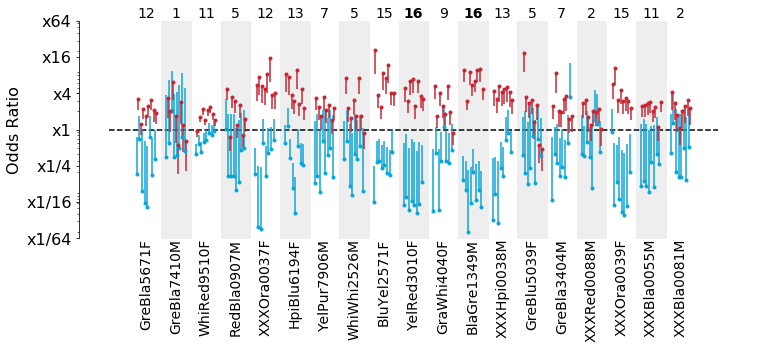

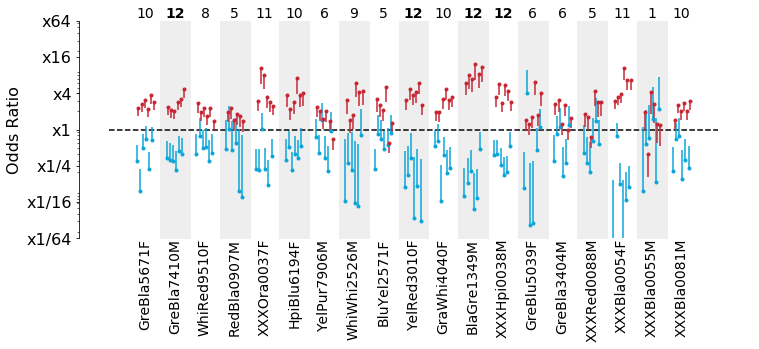

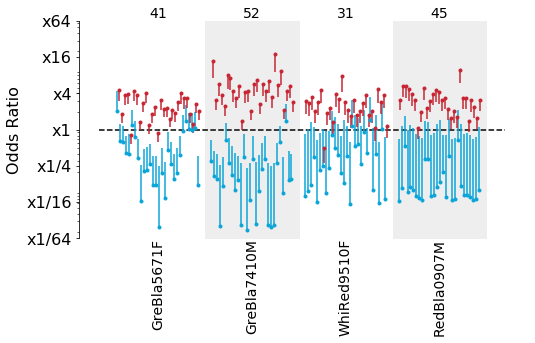

In [11]:
yscale = [-6, 6]

for test in ["SovsSo_8v8_d2", "DCvsDC_6v6_d2", "AllvsAll_28v28"]:
    fig_height = 4
    if test == "AllvsAll_28v28":
        fig = plt.figure(figsize=(8, fig_height))
    else:
        fig = plt.figure(figsize=(12, fig_height))

    test_df = stim_level_df[stim_level_df["Test Context"] == test]
    
    # Current x-position of points to plot
    base_plot_pos = 0
    
    # Flag to alternate background shading between subjects
    shade_flag = False
    
    # Counters for number of subjects in test and number of subjects who memorized full set
    n_full = 0
    n_subjects = 0
    n_half = 0

    for subject in test_df.Subject.unique():
        rewarded = test_df[(test_df.Subject == subject) & (test_df["Stimulus Class"] == "Rewarded")]
        nonrewarded = test_df[(test_df.Subject == subject) & (test_df["Stimulus Class"] == "Nonrewarded")]
        
        reward_x = np.arange(len(rewarded))
        nonreward_x = 0.5 + np.arange(len(nonrewarded))
        
        reward_err = rewarded["Odds Ratio"] - rewarded["95 CI Lower"], 
        plt.errorbar(
            base_plot_pos + reward_x,
            rewarded["Odds Ratio"],
            yerr=[
                [0] * len(rewarded),
                rewarded["95 CI Upper"] - rewarded["Odds Ratio"]
            ],
            color=color_by_reward.get("Rewarded"),
            marker=".",
            linestyle="none",
        )
        
        plt.errorbar(
            base_plot_pos + nonreward_x,
            nonrewarded["Odds Ratio"],
            yerr=[
                nonrewarded["Odds Ratio"] - nonrewarded["95 CI Lower"],
                [0] * len(nonrewarded)
            ],
            color=color_by_reward.get("Nonrewarded"),
            marker=".",
            linestyle="none",
        )
        
        # Shade in background alternatingly
        window_max = np.max(np.concatenate([reward_x, nonreward_x]))
        if shade_flag:
            plt.fill_between(
                [base_plot_pos - 2, base_plot_pos + window_max + 2],
                2**yscale[0], 2**yscale[1], zorder=-100, color="#EEEEEE"
            )
        
        midpt = base_plot_pos + (window_max / 2)
        sig_n, sig_max = mem_counts[(subject, test)]
        plt.text(
            midpt,
            2 ** yscale[1],
            "{}".format(sig_n),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontweight="bold" if sig_n == sig_max else None,
            fontsize=14,
        )
        plt.text(
            midpt,
            2 ** yscale[0],
            subject,
            horizontalalignment="center",
            verticalalignment="top",
            rotation=90,
            fontsize=14
        )
    
        shade_flag = not shade_flag
        base_plot_pos += window_max + 4
        
    ax = plt.gca()
    set_oddsratio_yticks(ax, biggest=yscale[1], smallest=yscale[0])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xticks([])

    plt.show()
    
    fig.savefig("figures/2_individual_results_{}.svg".format(test), format="svg", bbox_inches="tight")
    plt.close(fig)


## Supplementary Figure. Mixed effects testing effect of subject sex on task performance

Fig. S2. Results of mixed effects modeling of per-vocalizer log odds ratios.
The log odds-ratio was inverted for rewarded vocalizers ($log_2\frac{1}{OR}$) for a direct comparison to the non-rewarded condition ($log_2{OR}$). Call type (Song or DC) and subject sex were used as fixed effects and subject identity as the random effect. Task performance was not significantly affected by subject sex (p=0.227) and performance was slightly higher for songs than distance calls (p=0.150). Error bars show 95% confidence intervals.


In [12]:
sex_differences_df = stim_level_df[stim_level_df["Test Context"].isin(["SovsSo_8v8_d2", "DCvsDC_6v6_d2"])]

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
==============================================================================================
Model:                       MixedLM            Dependent Variable:            Q("Odds Ratio")
No. Observations:            532                Method:                        REML           
No. Groups:                  20                 Scale:                         6.1476         
Min. group size:             12                 Log-Likelihood:                -1247.0823     
Max. group size:             28                 Converged:                     Yes            
Mean group size:             26.6                                                             
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                            1.983    0.312  6.358 0.000  1.372  2.594
Q("Stimulus Call Type")[T.SO]                        0.450    0.324  1.388 0.165 -0.185  1.086
Q("Subject Sex")[T.M]                               -0.183    0.432 -0.424 0.672 -1.030  0.664
Q("Stimulus Call Type")[T.SO]:Q("Subject Sex")[T.M] -0.467    0.441 -1.058 0.290 -1.332  0.398
Group Var                                            0.382    0.084                           
==============================================================================================

"""

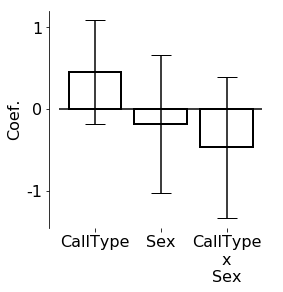

In [13]:
md = smf.mixedlm(
    "Q(\"Odds Ratio\") ~ "
    "Q(\"Stimulus Call Type\") + "
    "Q(\"Subject Sex\") +"
    "Q(\"Stimulus Call Type\") * Q(\"Subject Sex\")",
    sex_differences_df,
    groups=sex_differences_df["Subject"])
mdf = md.fit()
summary = mdf.summary()
display(summary)

sumtable = summary.tables[1]

def get_err(key):
    return (
        np.abs(float(sumtable.loc[key]["Coef."]) - float(sumtable.loc[key]["[0.025"])),
        np.abs(float(sumtable.loc[key]["Coef."]) - float(sumtable.loc[key]["0.975]"])),
    )

fig = plt.figure(figsize=(4, 4))
plt.bar(
    [0, 1, 2],
    [
        float(sumtable.loc["Q(\"Stimulus Call Type\")[T.SO]"]["Coef."]),
        float(sumtable.loc["Q(\"Subject Sex\")[T.M]"]["Coef."]),
        float(sumtable.loc["Q(\"Stimulus Call Type\")[T.SO]:Q(\"Subject Sex\")[T.M]"]["Coef."])
    ],
    yerr=[
        [
            get_err("Q(\"Stimulus Call Type\")[T.SO]")[0],
            get_err("Q(\"Subject Sex\")[T.M]")[0], 
            get_err("Q(\"Stimulus Call Type\")[T.SO]:Q(\"Subject Sex\")[T.M]")[0]
        ],
        [
            get_err("Q(\"Stimulus Call Type\")[T.SO]")[1], 
            get_err("Q(\"Subject Sex\")[T.M]")[1],
            get_err("Q(\"Stimulus Call Type\")[T.SO]:Q(\"Subject Sex\")[T.M]")[1]
        ],
    ],
    capsize=10,
    facecolor="White",
    edgecolor="k",
    linewidth=2
)

plt.xticks([0, 1, 2], [
    "CallType",
    "Sex",
    "CallType\nx\nSex"    
], fontsize=16)
plt.yticks([-1, 0, 1], [-1, 0, 1], fontsize=16)
plt.hlines([0], *plt.xlim())

plt.ylabel("Coef.", fontsize=16)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

fig.savefig("figures/S2_sex.svg", format="svg", bbox_inches="tight")
plt.close(fig)

## Figure 3A and 3B. Learning curves as function of informative trials

A&B. Learning curves are analyzed by plotting the behavioral response (probability of interruption) as a function of informative trials (see text) for rewarded (Re; blue) and non-rewarded vocalizers (NoRe; red).

In [14]:
from functools import partial


def inject_relative_informative_trials(df):
    """Takes a dataframe with a subset of trials and injects a column of "Relative Informative Trials Seen"
    which indicates the number of informative trials seen by a subject for a given vocalizer in the
    selected range
    """
    df = df.copy()
    df["Relative Informative Trials Seen"] = df["Informative Trials Seen"]
    for (subj, vocalizer, call_type), subdf in df.groupby(["Subject", "Stimulus Vocalizer", "Stimulus Call Type"]):
        df.loc[
            subdf.index,
            "Relative Informative Trials Seen"
        ] -= subdf.iloc[0]["Informative Trials Seen"]
    
    return df


def generate_informative_trial_dataframe(df, informative_trials):
    """Generate a dataframe with interruption data per bin per subject per stimulus
    from the selected trials
    """
    # The "Informative Trials Seen" column counts informative trials seen for a given stim across
    # all sessions run for a subject. The given dataframe may only include trials from a selected
    # epoch which may not include the first sessions. So we create a new "Relative Informative Trials Seen"
    # column that shows number of informative trials seen relative to the start of the requested range.
    df = inject_relative_informative_trials(df)
    output_rows = []
    for bin_idx in informative_trials:
        bin_df = df[df["Relative Informative Trials Seen"] == bin_idx]
        for (subject, subject_sex, vocalizer, call_type, rewarded), stim_df in bin_df.groupby([
                    "Subject", "Subject Sex", "Stimulus Vocalizer", "Stimulus Call Type", "Stimulus Class"
                ]):
            output_rows.append([
                subject,
                subject_sex,
                vocalizer,
                call_type,
                rewarded,
                bin_idx,
                len(stim_df),
                np.mean(stim_df["Interrupt"])  # This should be just 1 / len(stim_df)
            ])
            
    return pd.DataFrame(output_rows, columns=["Subject", "Subject Sex", "Stimulus Vocalizer", "Stimulus Call Type",
            "Stimulus Class", "Relative Informative Trials Seen", "Bin Size", "p(interrupt)"])


def process_learning_curve_data(df, informative_trials):
    """
    Collect probability of interruption across subjects in each informative trial bin
    
    df: pandas DataFrame filtered down to the trials of interest
    informative_trials: numpy array of integers for the informative trial bins requested (e.g. np.arange(10))
    """
    inform_df = generate_informative_trial_dataframe(df, informative_trials)
    
    grouped_by_informative_trials = inform_df.groupby([
        "Subject", "Relative Informative Trials Seen", "Stimulus Class"
    ]).mean()["p(interrupt)"]

    binned = grouped_by_informative_trials.groupby(
        ["Relative Informative Trials Seen", "Stimulus Class"],
    )
    
    output_rows = []
    for (bin_idx, rewarded), subdf in binned:
        mean, sem = jackknife(subdf, np.mean)
        output_rows.append([bin_idx, rewarded, mean, sem])
    output = pd.DataFrame(output_rows, columns=["Informative Trials", "Stimulus Class", "p(interrupt)", "SEM"])
    output = output.sort_values(["Informative Trials", "Stimulus Class"])

    return output


def plot_learning_curve(df, informative_trials, ax, fill_kwargs, n_sem=2, line_kwargs=None):
    """
    Plot the learning curve across subjects for the given trials
    
    df: pandas DataFrame filtered down to the trials of interest
    informative_trials: numpy array of integers for the informative trial bins requested (e.g. np.arange(10))
    """
    learning_df = process_learning_curve_data(df, informative_trials)
    
    for stimulus_class in ["Rewarded", "Nonrewarded"]:
        subdf = learning_df[learning_df["Stimulus Class"] == stimulus_class]
        ax.fill_between(
            subdf["Informative Trials"],
            subdf["p(interrupt)"] - 2 * subdf["SEM"],
            subdf["p(interrupt)"] + 2 * subdf["SEM"],
            color=color_by_reward.get(stimulus_class),
            **fill_kwargs
        )
        if line_kwargs is not None:
            ax.plot(
                subdf["Informative Trials"],
                subdf["p(interrupt)"],
                color=color_by_reward.get(stimulus_class),
                **line_kwargs
            )
    return learning_df

In [15]:
def plot_learning_curves_side_by_side(df1, df2, informative_trials, ylim=(0, 1)):
    fig = plt.figure(figsize=(10, 4))

    ax_left = fig.add_axes([0.1, 0.1, 0.4, 0.8])
    ax_right = fig.add_axes([0.6, 0.1, 0.4, 0.8])

    df1 = plot_learning_curve(
        df1,
        informative_trials,
        ax_left,
        fill_kwargs=dict(
            alpha=0.2,
            zorder=-1,
        ),
        line_kwargs = dict(
            marker="x",
            markersize=8,
        )
    )

    df2 = plot_learning_curve(
        df2,
        informative_trials,
        ax_right,
        fill_kwargs=dict(
            alpha=0.4,
            zorder=-1,
        ),
        line_kwargs = dict(
            marker="o",
            markersize=5,
        )
    )

    for ax in [ax_left, ax_right]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        #Create legend from custom artist/label lists
        if ax is ax_right:
            unreartist = plt.Line2D((0,1),(0,0), color=color_by_reward.get("Unrewarded"), marker='', linestyle='-')
            reartist = plt.Line2D((0,1),(0,0), color=color_by_reward.get("Rewarded"), marker='', linestyle='-')
            dc_artist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='-', markersize=8)
            song_artist = plt.Line2D((0,1),(0,0), color='k', marker='x', linestyle='-')
            ax.legend(
                [unreartist, reartist, dc_artist, song_artist], 
                ["NoRe", "Re", "DC", "Song"],
                ncol=2, 
                frameon=False,
                fontsize=16
            )

        # Set limits and axes of plot
        xticks = np.arange(0, np.max(informative_trials) + 2, 10).astype(np.int)
        ax.set_xlim(0, np.max(informative_trials))
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks, fontsize=16)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)

        if ax is ax_left:
            ax.set_ylabel("Prob. of interruption", fontsize=16)
        ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)

        ax.set_ylim(*ylim)

    return fig, df1, df2

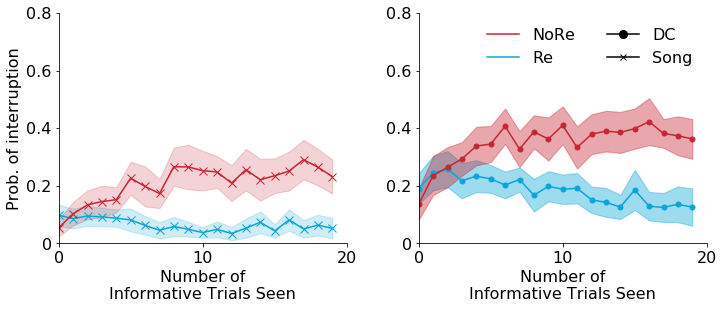

In [16]:
fig, df1, df2 = plot_learning_curves_side_by_side(
    df[df["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    df[df["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    informative_trials=np.arange(20),
    ylim=(0, 0.8)
)

plt.show()

fig.savefig("figures/3AB_learning_curves.svg", format="svg", bbox_inches="tight")

plt.close(fig)

### Get baseline probability of interruption (when k=0)

One can also notice that the default "baseline" interruption rates differed between songs and distance calls when no informative trials have been seen (Song baseline = 0.8 ± 0.01 (two SEM), DC baseline = 0.16 ± 0.02, mixed effects models < 0.001). The difference in the baseline interruption rates or the learning curve between male and female subjects was not significant (mixed effects models, p=0.563). 

In [17]:
song_baseline = generate_informative_trial_dataframe(
    df[df["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    informative_trials=np.array([0]),
)
mean, sem = jackknife(song_baseline["p(interrupt)"], np.mean)
print("Song baseline prob. interruption (k=0): {:.2f} ({:.2f})".format(mean, sem))

dc_baseline = generate_informative_trial_dataframe(
    df[df["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    informative_trials=np.array([0]),
)
mean, sem = jackknife(dc_baseline["p(interrupt)"], np.mean)
print("DC baseline prob. interruption (k=0): {:.2f} ({:.2f})".format(mean, sem))


Song baseline prob. interruption (k=0): 0.08 (0.01)
DC baseline prob. interruption (k=0): 0.16 (0.02)


/auto/fhome/kevin/Projects/zebra-finch-memory/env/lib/python3.5/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
==============================================================================================
Model:                       MixedLM           Dependent Variable:           Q("p(interrupt)")
No. Observations:            560               Method:                       REML             
No. Groups:                  20                Scale:                        0.0546           
Min. group size:             28                Log-Likelihood:               1.9186           
Max. group size:             28                Converged:                    Yes              
Mean group size:             28.0                                                             
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                            0.174    0.027  6.527 0.000  0.122  0.226
Q("Stimulus Call Type")[T.SO]                       -0.113    0.028 -3.999 0.000 -0.168 -0.058
Q("Subject Sex")[T.M]                               -0.022    0.038 -0.578 0.563 -0.096  0.052
Q("Stimulus Call Type")[T.SO]:Q("Subject Sex")[T.M]  0.051    0.040  1.278 0.201 -0.027  0.129
Group Var                                            0.003    0.007                           
==============================================================================================

"""

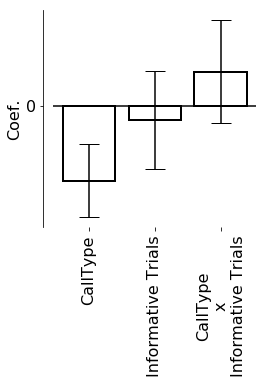

In [18]:
# Create a stacked baseline dataframe to run a mixed effects model on (with subject, vocalizer, p(interrupt))
stacked_baseline = pd.concat([song_baseline, dc_baseline])

md = smf.mixedlm(
    "Q(\"p(interrupt)\") ~ "
    "Q(\"Stimulus Call Type\") + "
    "Q(\"Subject Sex\") +"
    "Q(\"Stimulus Call Type\") * Q(\"Subject Sex\")",
    stacked_baseline,
    groups=stacked_baseline["Subject"])
mdf = md.fit()
summary = mdf.summary()
display(summary)

sumtable = summary.tables[1]

def get_err(key):
    return (
        np.abs(float(sumtable.loc[key]["Coef."]) - float(sumtable.loc[key]["[0.025"])),
        np.abs(float(sumtable.loc[key]["Coef."]) - float(sumtable.loc[key]["0.975]"])),
    )

fig = plt.figure(figsize=(4, 4))
plt.bar(
    [0, 1, 2],
    [
        float(sumtable.loc["Q(\"Stimulus Call Type\")[T.SO]"]["Coef."]),
        float(sumtable.loc["Q(\"Subject Sex\")[T.M]"]["Coef."]),
        float(sumtable.loc["Q(\"Stimulus Call Type\")[T.SO]:Q(\"Subject Sex\")[T.M]"]["Coef."])
    ],
    yerr=[
        [
            get_err("Q(\"Stimulus Call Type\")[T.SO]")[0],
            get_err("Q(\"Subject Sex\")[T.M]")[0], 
            get_err("Q(\"Stimulus Call Type\")[T.SO]:Q(\"Subject Sex\")[T.M]")[0]
        ],
        [
            get_err("Q(\"Stimulus Call Type\")[T.SO]")[1], 
            get_err("Q(\"Subject Sex\")[T.M]")[1],
            get_err("Q(\"Stimulus Call Type\")[T.SO]:Q(\"Subject Sex\")[T.M]")[1]
        ],
    ],
    capsize=10,
    facecolor="White",
    edgecolor="k",
    linewidth=2
)

plt.xticks([0, 1, 2], [
    "CallType",
    "Informative Trials",
    "CallType\nx\nInformative Trials"    
], rotation=90, fontsize=16)
plt.yticks([-1, 0, 1], [-1, 0, 1], fontsize=16)
plt.hlines([0], *plt.xlim())

plt.ylabel("Coef.", fontsize=16)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

# fig.savefig("figures/S5_learning_mixed_2.svg", format="svg", bbox_inches="tight")
plt.close(fig)

## Figure 3C and 3D

C&D. The separation between the red and blue curves that quantifies the learning is expressed as the difference in the log odds ratio between non-rewarded and rewarded vocalizers (C: song and D: DC). Asterisk indicates significantly different from chance level at 0 (p < 0.05, Bonferroni corrected). Shaded regions show 2 SEM.



In [19]:
# Stats
song_df = generate_informative_trial_dataframe(
    df[df["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    np.arange(20)
)
for bin_idx, subdf in song_df.groupby("Relative Informative Trials Seen"):
    rew_df = subdf[subdf["Stimulus Class"] == "Rewarded"].groupby("Subject").mean()
    norew_df = subdf[subdf["Stimulus Class"] == "Nonrewarded"].groupby("Subject").mean()
    
    test = scipy.stats.ttest_rel(
        rew_df["p(interrupt)"] / (1 - rew_df["p(interrupt)"]),
        norew_df["p(interrupt)"] / (1 - norew_df["p(interrupt)"])
    )

dc_df = generate_informative_trial_dataframe(
    df[df["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    np.arange(20)
)
for bin_idx, subdf in dc_df.groupby("Relative Informative Trials Seen"):
    rew_df = subdf[subdf["Stimulus Class"] == "Rewarded"].groupby("Subject").mean()
    norew_df = subdf[subdf["Stimulus Class"] == "Nonrewarded"].groupby("Subject").mean()
    
    test = scipy.stats.ttest_rel(
        rew_df["p(interrupt)"] / (1 - rew_df["p(interrupt)"]),
        norew_df["p(interrupt)"] / (1 - norew_df["p(interrupt)"])   
    )

In [20]:
def group_by_subject(df, informative_trials):
    """
    Collect probability of interruption across subjects in each informative trial bin
    
    df: pandas DataFrame filtered down to the trials of interest
    informative_trials: numpy array of integers for the informative trial bins requested (e.g. np.arange(10))
    """
    inform_df = generate_informative_trial_dataframe(df, informative_trials)

    # If a subject interrupted all trials or did not interrupt at all within
    # one bin, we want to replace that by a generic interruption probability.
    # We will use 1/2 the average probability of interruption within that bin
    # across all subjects.
    baselines = inform_df.groupby([
        "Relative Informative Trials Seen", "Stimulus Class"
    ]).mean()["p(interrupt)"]

    # Generate a dataframe with the log odds of interruption for Rewarded
    # and Nonrewarded trials for each subject in each informative trial bin.
    binned = inform_df.groupby(
        ["Relative Informative Trials Seen", "Subject"],
    )
    by_subject_rows = []
    for (bin_idx, subject), subdf in binned:
        baseline_p_rew = baselines.loc[bin_idx, "Rewarded"] / 2
        baseline_p_norew = baselines.loc[bin_idx, "Nonrewarded"] / 2

        rew = subdf[subdf["Stimulus Class"] == "Rewarded"]
        norew = subdf[subdf["Stimulus Class"] == "Nonrewarded"]
        
        p_rew = np.mean(rew["p(interrupt)"])
        p_norew = np.mean(norew["p(interrupt)"])
        p_rew = p_rew or baseline_p_rew
        p_norew = p_norew or baseline_p_norew
        
        norew_logodds = np.log2(p_norew / (1 - p_norew))
        rew_logodds = np.log2(p_rew / (1 - p_rew))
        
        by_subject_rows.append({
            "Log(OR)": norew_logodds - rew_logodds,
            "Subject": subject,
            "Rewarded Log Odds": rew_logodds,
            "Nonrewarded Log Odds": norew_logodds,
            "Relative Informative Trials Seen": bin_idx
        })
    by_subject_df = pd.DataFrame(by_subject_rows)
    
    return by_subject_df


def summarize_across_subjects(grouped_df):
    result_rows = []
    for bin_idx, subdf in grouped_df.groupby("Relative Informative Trials Seen"):
        # Stats
        # Run a paried t test in each bin to test if p_unrew > p_re
        t_stat, p_val = scipy.stats.ttest_rel(subdf["Nonrewarded Log Odds"], subdf["Rewarded Log Odds"])
        p_val = p_val / 2
        
        mean, sem = jackknife(subdf["Log(OR)"], np.mean)
        result_rows.append({
            "Relative Informative Trials Seen": bin_idx,
            "Log(OR)": mean,
            "SEM": sem,
            "p-value": p_val if t_stat > 0 else 1.0
        })

    
    result_df = pd.DataFrame(result_rows)
    
    return result_df


def plot_learning_curve_2(df, informative_trials, ax, fill_kwargs, n_sem=2, line_kwargs=None):
    """
    Plot the learning curve across subjects for the given trials
    
    df: pandas DataFrame filtered down to the trials of interest
    informative_trials: numpy array of integers for the informative trial bins requested (e.g. np.arange(10))
    """
    learning_df = group_by_subject(df, informative_trials)
    result_df = summarize_across_subjects(learning_df).sort_values("Relative Informative Trials Seen")
    
    ax.fill_between(
        result_df["Relative Informative Trials Seen"],
        result_df["Log(OR)"] - 2 * result_df["SEM"],
        result_df["Log(OR)"] + 2 * result_df["SEM"],
        **fill_kwargs
    )
    
    ax.plot(
        result_df["Relative Informative Trials Seen"],
        result_df["Log(OR)"],
        **line_kwargs
    )
    
    return result_df

Song
Significance test (False discovery rate): [False False  True  True  True  True  True  True  True  True  True]


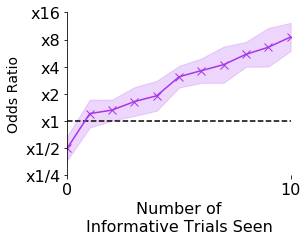

DC
Significance test (False discovery rate): [False False False  True  True  True  True  True  True  True  True]


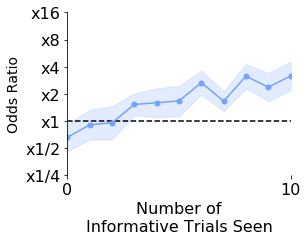

In [21]:
color_by_call = {
    "SO": "#a834eb",
    "DC": "#73a2ff",
}

print("Song")
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()
so_result_df = plot_learning_curve_2(
    df[df["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    np.arange(11),
    ax,
    fill_kwargs=dict(
        color=color_by_call.get("SO"),
        alpha=0.2,
        zorder=-1,
    ),
    line_kwargs = dict(
        color=color_by_call.get("SO"),
        marker="x",
        markersize=8,
    )
)

print("Significance test (False discovery rate): {}".format(false_discovery(so_result_df["p-value"])))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Set limits and axes of plot
ax.set_xlim(0, 10)
ax.set_xticks([0, 10])
ax.set_xticklabels([0, 10], fontsize=16)
ax.set_yticks([-1, 0, 1, 2, 3])
ax.set_yticklabels([-1, 0, 1, 2, 3], fontsize=16)
ax.hlines(0, *plt.xlim(), zorder=-1, linestyle="--", color="black")

ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)
set_oddsratio_yticks(ax, biggest=4, smallest=-2, convert_log=False)
ax.set_ylim(-2.0, 4)
ax.set_ylabel(r"Odds Ratio", fontsize=14)# , rotation=0, horizontalalignment="right")

plt.show()
fig.savefig("figures/3CD_learning_curves_song.svg", format="svg", bbox_inches="tight")

plt.close(fig)

print("DC")
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()
dc_result_df = plot_learning_curve_2(
    df[df["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    np.arange(11),
    ax,
    fill_kwargs=dict(
        color=color_by_call.get("DC"),
        alpha=0.2,
        zorder=-1,
    ),
    line_kwargs = dict(
        color=color_by_call.get("DC"),
        marker="o",
        markersize=5,
    )
)
print("Significance test (False discovery rate): {}".format(false_discovery(dc_result_df["p-value"])))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Set limits and axes of plot
ax.set_xlim(0, 10)
ax.set_xticks([0, 10])
ax.set_xticklabels([0, 10], fontsize=16)
ax.set_yticks([-1, 0, 1, 2, 3])
ax.set_yticklabels([-1, 0, 1, 2, 3], fontsize=16)
ax.hlines(0, *plt.xlim(), zorder=-1, linestyle="--", color="black")

ax.set_xlabel("Number of\nInformative Trials Seen", fontsize=16)
set_oddsratio_yticks(ax, biggest=4, smallest=-2, convert_log=False)
ax.set_ylim(-2.0, 4.0)
ax.set_ylabel(r"Odds Ratio", fontsize=14)# , rotation=0, horizontalalignment="right")

plt.show()

fig.savefig("figures/3CD_learning_curves_dc.svg", format="svg", bbox_inches="tight")
plt.close(fig)


### Difference in learning rate between songs and distance calls

There is a non-significant trend of call type on the slope, suggesting that songs may be learned with fewer examples.

In [22]:
# Generate a combined dataframe for mixed effects model
# It will have the data binned by informative trials (including only up to the 10th informative trial)
# of each subject's log(OR) for that informative trial bin

combined_rows = []
so_group = group_by_subject(
    df[df["Test Context"].isin(["SovsSo_1v1", "SovsSo_4v4", "SovsSo_8v8_d1", "SovsSo_8v8_d2"])],
    np.arange(11),
)
for i in range(len(so_group)):
    row = so_group.iloc[i]
    combined_rows.append({
        "Log(OR)": row["Log(OR)"],
        "Subject": row["Subject"],
        "Relative Informative Trials Seen": row["Relative Informative Trials Seen"],
        "Call Type": "SO",
    })
    
dc_group = group_by_subject(
    df[df["Test Context"].isin(["DCvsDC_1v1", "DCvsDC_4v4", "DCvsDC_6v6_d1", "DCvsDC_6v6_d2"])],
    np.arange(11),
)
for i in range(len(dc_group)):
    row = dc_group.iloc[i]
    combined_rows.append({
        "Log(OR)": row["Log(OR)"],
        "Subject": row["Subject"],
        "Relative Informative Trials Seen": row["Relative Informative Trials Seen"],
        "Call Type": "DC",
    })
    

combined_df = pd.DataFrame(combined_rows)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Mixed Linear Model Regression Results
=====================================================================================================
Model:                           MixedLM               Dependent Variable:               Q("Log(OR)")
No. Observations:                440                   Method:                           REML        
No. Groups:                      20                    Scale:                            1.3067      
Min. group size:                 22                    Log-Likelihood:                   -697.8652   
Max. group size:                 22                    Converged:                        Yes         
Mean group size:                 22.0                                                                
-----------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept                                                  -0.322    0.157 -2.052 0.040 -0.629 -0.014
Q("Call Type")[T.SO]                                       -0.117    0.204 -0.573 0.567 -0.516  0.283
Q("Relative Informative Trials Seen")                       0.208    0.024  8.552 0.000  0.161  0.256
Q("Call Type")[T.SO]:Q("Relative Informative Trials Seen")  0.155    0.034  4.495 0.000  0.087  0.222
Group Var                                                   0.076    0.039                           
=====================================================================================================

"""

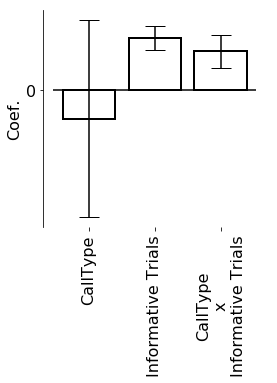

In [23]:
md = smf.mixedlm(
    "Q(\"Log(OR)\") ~ "
    "Q(\"Call Type\") + "
    "Q(\"Relative Informative Trials Seen\") +"
    "Q(\"Call Type\") * Q(\"Relative Informative Trials Seen\")",
    combined_df,
    groups=combined_df["Subject"])
mdf = md.fit()
summary = mdf.summary()
display(summary)

sumtable = summary.tables[1]

def get_err(key):
    return (
        np.abs(float(sumtable.loc[key]["Coef."]) - float(sumtable.loc[key]["[0.025"])),
        np.abs(float(sumtable.loc[key]["Coef."]) - float(sumtable.loc[key]["0.975]"])),
    )

fig = plt.figure(figsize=(4, 4))
plt.bar(
    [0, 1, 2],
    [
        float(sumtable.loc["Q(\"Call Type\")[T.SO]"]["Coef."]),
        float(sumtable.loc["Q(\"Relative Informative Trials Seen\")"]["Coef."]),
        float(sumtable.loc["Q(\"Call Type\")[T.SO]:Q(\"Relative Informative Trials Seen\")"]["Coef."])
    ],
    yerr=[
        [
            get_err("Q(\"Call Type\")[T.SO]")[0],
            get_err("Q(\"Relative Informative Trials Seen\")")[0], 
            get_err("Q(\"Call Type\")[T.SO]:Q(\"Relative Informative Trials Seen\")")[0]
        ],
        [
            get_err("Q(\"Call Type\")[T.SO]")[1], 
            get_err("Q(\"Relative Informative Trials Seen\")")[1],
            get_err("Q(\"Call Type\")[T.SO]:Q(\"Relative Informative Trials Seen\")")[1]
        ],
    ],
    capsize=10,
    facecolor="White",
    edgecolor="k",
    linewidth=2
)

plt.xticks([0, 1, 2], [
    "CallType",
    "Informative Trials",
    "CallType\nx\nInformative Trials"    
], rotation=90, fontsize=16)
plt.yticks([-1, 0, 1], [-1, 0, 1], fontsize=16)
plt.hlines([0], *plt.xlim())

plt.ylabel("Coef.", fontsize=16)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

fig.savefig("figures/S4_learning_mixed_effects.svg", format="svg", bbox_inches="tight")
plt.close(fig)

## Extra: Learning curves for other epochs

### Day 2 of SovsSo_8v8 and DCvsDC_6v6 (late in learning)

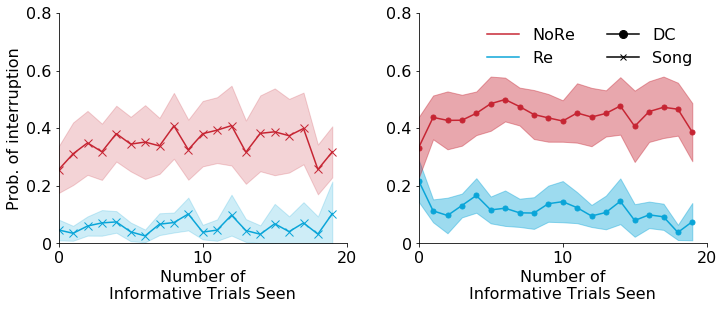

In [24]:
_ = plot_learning_curves_side_by_side(
    df[df["Test Context"].isin(["SovsSo_8v8_d2"])],
    df[df["Test Context"].isin(["DCvsDC_6v6_d2"])],
    informative_trials=np.arange(20),
    ylim=(0, 0.8)
)

### All vocalizers (32 songs, 24 DCs) when songs and DCs are combined in the same sessions

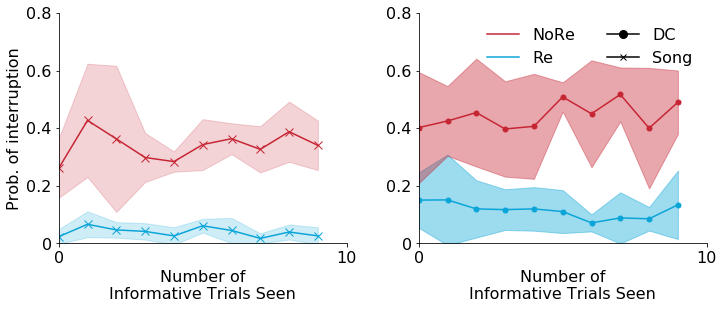

In [25]:
_ = plot_learning_curves_side_by_side(
    df[
        df["Test Context"].isin(["AllvsAll_4v4", "AllvsAll_28v28"]) &
        (df["Stimulus Call Type"] == "SO") &
        (df["Condition"] == "None")
    ],
    df[
        df["Test Context"].isin(["AllvsAll_4v4", "AllvsAll_28v28"]) &
        (df["Stimulus Call Type"] == "DC") &
        (df["Condition"] == "None")
    ],
    informative_trials=np.arange(10),
    ylim=(0, 0.8)
)

### All vocalizers (32 songs, 24 DCs) when songs and DCs are combined in the same sessions

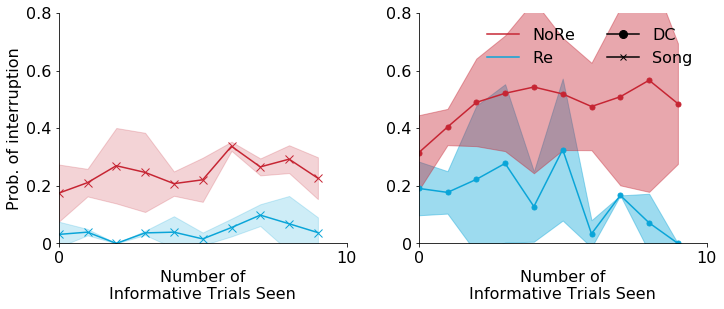

In [26]:
_ = plot_learning_curves_side_by_side(
    df[
        df["Test Context"].isin(["AllvsAll_4v4", "AllvsAll_28v28"]) &
        (df["Stimulus Call Type"] == "SO") &
        (df["Condition"] == "MonthLater")
    ],
    df[
        df["Test Context"].isin(["AllvsAll_4v4", "AllvsAll_28v28"]) &
        (df["Stimulus Call Type"] == "DC") &
        (df["Condition"] == "MonthLater")
    ],
    informative_trials=np.arange(10),
    ylim=(0, 0.8)
)

## Figure 4. Generalization across renditions

Similar logic to Informative Trials analysis, but looking at the probability that any given subject will interrupt the kth heard rendition of a stimulus for any given vocalizer.

A&B. The plots show the average probability of interruption across all subjects for each of the ten renditions the first time they are heard by the subject; the renditions are ordered on the x-axis according to the order it is presented.  Error bars are 2 SEM. 

In [27]:
from functools import partial
from collections import defaultdict
from stats import linreg


def find_first_trial_per_rendition(df):
    """For each subject and vocalizer/calltype in the dataframe
    
    Make a row for the trial representing the very first time that file was presented
    """
    df = df.copy()
    
    def clean_stimulus_file(file):
        if file[-6:] in ["_0.wav", "_1.wav", "_2.wav", "_3.wav"]:
            file = file[:-6] + file[-4:]
        return file

    df["Stimulus File"] = df["Stimulus File"].apply(clean_stimulus_file)
    df["First Presentation of File"] = False
    df["kth Presentation of Vocalizer"] = np.nan

    stimulus_vocalizer_counts = defaultdict(int)
    for (subject, _, vocalizer, call_type), subdf in df.sort_values("Time").groupby([
                "Subject", "Stimulus File", "Stimulus Vocalizer", "Stimulus Call Type"
            ], sort=False):
        k = stimulus_vocalizer_counts[(subject, vocalizer, call_type)]
        subdf = subdf.sort_values("Time")
        df.loc[subdf.index[0], "First Presentation of File"] = True
        df.loc[subdf.index[0], "kth Presentation of Vocalizer"] = k
        stimulus_vocalizer_counts[(subject, vocalizer, call_type)] += 1
        
    result = df[df["First Presentation of File"] == True]
    return result


def collapse_first_trials_per_rendition(df):
    """Collapse the output of find_first_trial_per_rendition across vocalizers
    """
    df = find_first_trial_per_rendition(df)
    output_rows = []
    for (subject, kth_presentation, call_type, stimulus_class), subdf in df.groupby([
                "Subject", "kth Presentation of Vocalizer", "Stimulus Call Type", "Stimulus Class"
            ]):
        output_rows.append([
            subject,
            kth_presentation,
            call_type,
            stimulus_class,
            np.mean(subdf["Interrupt"])
        ])
    return pd.DataFrame(output_rows,
            columns=["Subject", "kth Presentation", "Call Type", "Class", "p(interrupt)"])


def group_by_kth_presentation(df):
    df = collapse_first_trials_per_rendition(df)
    
    output_rows = []
    for (kth_presentation, stimulus_class, call_type), subdf in df.groupby(["kth Presentation", "Class", "Call Type"]):
        p = subdf["p(interrupt)"]
        mean_p, sem = jackknife(p, np.mean)
        
        output_rows.append([
            kth_presentation,
            stimulus_class,
            call_type,
            mean_p,
            sem
        ])
    return pd.DataFrame(output_rows,
        columns=["kth Presentation", "Class", "Call Type", "p(interrupt)", "SEM"])

In [28]:
result = group_by_kth_presentation(df)

Song Rewarded R2 = 0.75 R2_adj = 0.71
Song Nonrewarded R2 = 0.92 R2_adj = 0.90


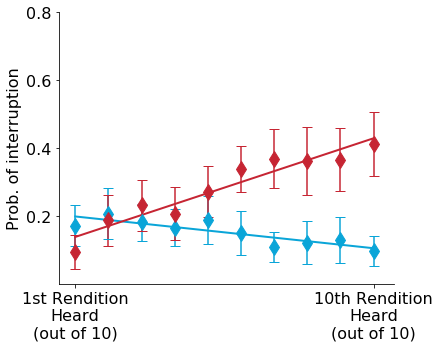

DC Rewarded R2 = 0.11 R2_adj = -0.00
DC Nonrewarded R2 = 0.83 R2_adj = 0.81


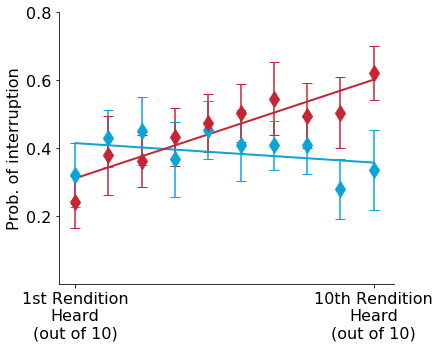

In [29]:
fig = plt.figure(figsize=(6, 5))
rew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_song["kth Presentation"],
    rew_song["p(interrupt)"],
    yerr=2*rew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded")
)
norew_song = result[(result["Call Type"] == "SO") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_song["kth Presentation"], 
    norew_song["p(interrupt)"],
    yerr=2*norew_song["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded")
)

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_song["kth Presentation"], rew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_song["kth Presentation"], norew_song["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("Song", "Nonrewarded", r_squared, r_adj))
plt.plot(
    rew_song["kth Presentation"], 
    lin(rew_song["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 0.8)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

fig.savefig("figures/4A_song_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)


fig = plt.figure(figsize=(6, 5))
rew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Rewarded")]
plt.errorbar(
    rew_dc["kth Presentation"],
    rew_dc["p(interrupt)"],
    yerr=2*rew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Rewarded"))
norew_dc = result[(result["Call Type"] == "DC") & (result["Class"] == "Nonrewarded")]
plt.errorbar(
    norew_dc["kth Presentation"], 
    norew_dc["p(interrupt)"],
    yerr=2*norew_dc["SEM"],
    marker="d",
    markersize=12,
    capsize=5,
    linestyle="None",
    color=color_by_reward.get("Nonrewarded"))

popt, pcov, lin, r_squared, r_adj, _ = linreg(rew_dc["kth Presentation"], rew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Rewarded", r_squared, r_adj))
plt.plot(
    rew_dc["kth Presentation"], 
    lin(rew_dc["kth Presentation"]),
    color=color_by_reward.get("Rewarded"),
    linewidth=2
)
popt, pcov, lin, r_squared, r_adj, _ = linreg(norew_dc["kth Presentation"], norew_dc["p(interrupt)"])
print("{} {} R2 = {:.2f} R2_adj = {:.2f}".format("DC", "Nonrewarded", r_squared, r_adj))
plt.plot(
    norew_dc["kth Presentation"], 
    lin(norew_dc["kth Presentation"]),
    color=color_by_reward.get("Nonrewarded"),
    linewidth=2
)

plt.xticks([0, 9], ["1st Rendition\nHeard\n(out of 10)", "10th Rendition\nHeard\n(out of 10)"], fontsize=16)
plt.xlim(-0.5, 9.6)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
plt.ylim(0, 0.8)
ax = plt.gca()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Prob. of interruption", fontsize=16)

plt.show()

fig.savefig("figures/4B_dc_generalization.svg", format="svg", bbox_inches="tight")

plt.close(fig)


## Figure 4C and 4D. Month later recall

If you take all trials before the first (N) informative trials in a given epoch, what is the probabiliy if interrupting (rewarded vs nonrewarded).

C&D. Interruption rates for non-rewarded and rewarded vocalizers in two subjects (top and bottom) during three epochs for distance calls (left) and songs (right). The three epochs shown are Naive (initial exposure to the stimuli), Learned (last two sessions of initial test), and Month Later (one month after Learned without any reinforcement). The interruption rates on a particular vocalizer are calculated from trials prior to the second informative trial of that vocalizer during the relevant epoch. Asterisks indicate epochs during which non-rewarded stimuli were interrupted at a significantly higher rate than rewarded stimuli (p<0.05, one-sided t-test). Error bars indicate 2 SEM.

In [30]:
month_later_epoch = df[
    (df["Condition"] == "MonthLater") & (df["Test Context"].apply(lambda x: x.startswith("AllvsAll")))
]

In [31]:
valid_subjects = month_later_epoch.Subject.unique()

In [32]:
epoch1 = df[(df["Condition"] != "MonthLater") & (df.Subject.isin(valid_subjects))]
epoch2 = df[
    (df["Condition"] != "MonthLater") &
    (df["Test Context"].apply(lambda x: x.startswith("AllvsAll"))) &
    (df.Subject.isin(valid_subjects))
]

In [33]:
# For each subject, for each informative trials limit, for each call type, for each reward class
informative_trials_limit = 2

output_rows = []

for epoch_name, epoch in [("Naive", epoch1), ("Learned", epoch2), ("MonthLater", month_later_epoch)]:
    epoch = inject_relative_informative_trials(epoch)
    for (subject, call_type, rewarded), epoch_grouped in epoch.groupby(["Subject", "Stimulus Call Type", "Stimulus Class"]):
        
        interruption_probabilities = []
        for vocalizer, stim_df in epoch_grouped.groupby(["Stimulus Vocalizer"]):
            subdf = stim_df[stim_df["Relative Informative Trials Seen"] <= informative_trials_limit]
            interruption_probabilities.append(np.mean(subdf["Interrupt"]))
        
        mean, sem = jackknife(interruption_probabilities, np.mean)
        output_rows.append([
            subject,
            informative_trials_limit,
            call_type,
            rewarded,
            epoch_name,
            interruption_probabilities,
            mean,
            sem,
        ])
            
result = pd.DataFrame(output_rows, columns=[
    "Subject", 
    "Informative Trials", 
    "Stimulus Call Type",
    "Stimulus Class", 
    "Epoch",
    "p(interrupt,stim)",
    "p(interrupt)",
    "SEM",
])

In [34]:
# Stats (t test in each epoch)

informative_trials_limit = 2

for epoch_name, epoch in [("Naive", epoch1), ("Learned", epoch2), ("MonthLater", month_later_epoch)]:
    epoch = inject_relative_informative_trials(epoch)
    
    for (subject, call_type), epoch_grouped in epoch.groupby(["Subject", "Stimulus Call Type"]):
        print("Testing {} {} {}".format(subject, call_type, epoch_name))
        
        interruption_probabilities = {
            "Rewarded": [],
            "Nonrewarded": []
        }
        
        for (vocalizer, rewarded), stim_df in epoch_grouped.groupby(["Stimulus Vocalizer", "Stimulus Class"]):
            subdf = stim_df[stim_df["Relative Informative Trials Seen"] <= informative_trials_limit]
            interruption_probabilities[rewarded].append(np.mean(subdf["Interrupt"]))
        
        test = scipy.stats.ttest_rel(
            np.array(interruption_probabilities["Rewarded"]),
            np.array(interruption_probabilities["Nonrewarded"]),
        )
        
        print("p={:.5f} {}".format(test.pvalue / 2, "*" if (test.statistic < 0) and (test.pvalue / 2 < 0.05) else ""))
    

Testing GreBla5671F DC Naive
p=0.12481 
Testing GreBla5671F SO Naive
p=0.35167 
Testing GreBla7410M DC Naive
p=0.33253 
Testing GreBla7410M SO Naive
p=0.10683 
Testing GreBla5671F DC Learned
p=0.00079 *
Testing GreBla5671F SO Learned
p=0.00001 *
Testing GreBla7410M DC Learned
p=0.00032 *
Testing GreBla7410M SO Learned
p=0.00000 *
Testing GreBla5671F DC MonthLater
p=0.03166 *
Testing GreBla5671F SO MonthLater
p=0.00007 *
Testing GreBla7410M DC MonthLater
p=0.00702 *
Testing GreBla7410M SO MonthLater
p=0.00016 *


GreBla5671F DC


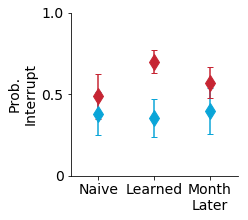

GreBla5671F SO


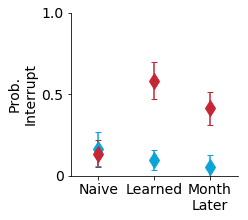

GreBla7410M DC


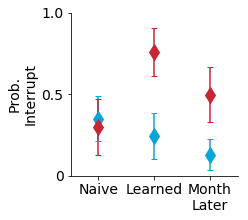

GreBla7410M SO


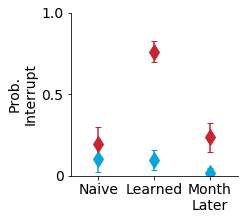

In [35]:
for (subject, call_type), subdf in result.groupby(["Subject", "Stimulus Call Type"]):
    print(subject, call_type)
    fig = plt.figure(figsize=(3, 3))
    for i, epoch in enumerate(["Naive", "Learned", "MonthLater"]):
        p_rew = subdf[(subdf["Epoch"] == epoch) & (subdf["Stimulus Class"] == "Rewarded")].iloc[0]["p(interrupt)"]
        sem_rew = subdf[(subdf["Epoch"] == epoch) & (subdf["Stimulus Class"] == "Rewarded")].iloc[0]["SEM"]
        p_norew = subdf[(subdf["Epoch"] == epoch) & (subdf["Stimulus Class"] == "Nonrewarded")].iloc[0]["p(interrupt)"]
        sem_norew = subdf[(subdf["Epoch"] == epoch) & (subdf["Stimulus Class"] == "Nonrewarded")].iloc[0]["SEM"]

        plt.errorbar(
            [i], 
            [p_rew],
            yerr=2*sem_rew,
            marker="d",
            capsize=3,
            markersize=12,
            color=color_by_reward.get("Rewarded"),
        )
        plt.errorbar(
            [i],
            [p_norew],
            yerr=2*sem_norew,
            marker="d",
            capsize=3,
            markersize=12,
            color=color_by_reward.get("Nonrewarded"),
        )
        
        ax = plt.gca()
        ax.set_ylabel("Prob.\nInterrupt", fontsize=14)

        ax.set_xlim(-0.5, 2.5)
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.5, 1.0])
        ax.set_yticklabels([0, 0.5, 1.0], fontsize=14)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(True)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(True)
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(["Naive", "Learned", "Month\nLater"], fontsize=14)

    plt.show()
    fig.savefig("figures/4CDEF_{}_{}_month_later.svg".format(subject, call_type), format="svg", bbox_inches="tight")
    plt.close(fig)


### Quantify change in performance between Learned and MonthLater

To do this, we want to test: for each subject, is their performance during the Learned epoch (AllvsAll_28v28) different from the odds ratio during the Month Later epoch (AllvsAll_28v28, one month later).

We can do this by assessing the mean change per-vocalizer. That is

For each subject we have 28 rewarded data points and 28 nonrewarded data points (odds ratios before and after month later). 


In [67]:
summary_df.loc[[38, 39, 42, 43]]

,Subject,Test Context,Condition,Odds Ratio,95 CI Lower,95 CI Upper,LogOR,SE(LogOR),p-value
38,GreBla5671F,AllvsAll_28v28,None,5.658855,4.869187,inf,1.733222,0.091447,1.830621e-91
39,GreBla7410M,AllvsAll_28v28,None,25.019431,20.351708,inf,3.219653,0.125817,6.285604e-223
42,GreBla5671F,AllvsAll_28v28,MonthLater,6.428875,4.997777,inf,1.860799,0.153485,1.858246e-39
43,GreBla7410M,AllvsAll_28v28,MonthLater,12.038263,8.766072,inf,2.488090,0.194024,2.908128e-57


In [62]:
z1 = (
    (summary_df.loc[42]["LogOR"] - summary_df.loc[38]["LogOR"]),
    np.sqrt(summary_df.loc[42]["SE(LogOR)"] ** 2 + summary_df.loc[38]["SE(LogOR)"] ** 2)
)

In [63]:
z2 = (
    (summary_df.loc[43]["LogOR"] - summary_df.loc[39]["LogOR"]),
    np.sqrt(summary_df.loc[43]["SE(LogOR)"] ** 2 + summary_df.loc[39]["SE(LogOR)"] ** 2)
)

In [64]:
z1

(0.12757796889104234, 0.1786624383903183)

In [65]:
z2

(-0.7315625897994051, 0.23124703218726472)

### Mixed effects tables and plots

#### Supp figure 2

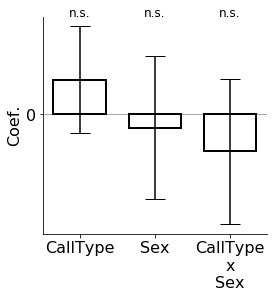

In [120]:
x_labels = ["CallType", "Sex", "CallType\nx\nSex"]
y_values = np.array([0.418, -0.163, -0.449])
y_stderr = np.array([0.325, 0.433, 0.442])

fig = plt.figure(figsize=(4, 4))
plt.bar([0, 1, 2], y_values, width=np.array([0.7, 0.7, 0.7]), yerr=2 * y_stderr,
    capsize=10,
    facecolor="White",
    edgecolor="k",
    linewidth=2
)

plt.xticks([0, 1, 2], x_labels, rotation=0, fontsize=16)
# plt.yticks([-1, 0, 1], [-1, 0, 1], fontsize=16)
plt.yticks([0], [0], fontsize=16)

plt.ylabel("Coef.", fontsize=16)
ax = plt.gca()
ax.spines["top"].set_visible(False)
# ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)

asterisk_y = plt.ylim()[1] * 1.1
plt.text(0, asterisk_y, "n.s.", fontsize=12, horizontalalignment="center", verticalalignment="top")
plt.text(1, asterisk_y, "n.s.", fontsize=12, horizontalalignment="center", verticalalignment="top")
plt.text(2, asterisk_y, "n.s.", fontsize=12, horizontalalignment="center", verticalalignment="top")

xlim = plt.xlim()
plt.hlines([0], *xlim, linestyle="-", color="DarkGrey", zorder=-1, linewidth=1)
plt.xlim(*xlim)

plt.show()
fig.savefig("figures/sfig2_sex_mixed_effects.svg", format="svg", bbox_inches="tight")
plt.close(fig)


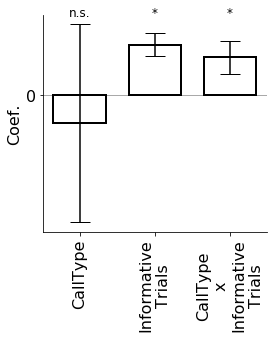

In [119]:
x_labels = ["CallType", "Informative\nTrials", "CallType\nx\nInformative\nTrials"]
y_values = np.array([-0.117, 0.208, 0.155])
y_stderr = np.array([0.204, 0.024, 0.034])

fig = plt.figure(figsize=(4, 4))
plt.bar([0, 1, 2], y_values, width=np.array([0.7, 0.7, 0.7]), yerr=2 * y_stderr,
    capsize=10,
    facecolor="White",
    edgecolor="k",
    linewidth=2
)

plt.xticks([0, 1, 2], x_labels, rotation=90, fontsize=16)
# plt.yticks([-1, 0, 1], [-1, 0, 1], fontsize=16)
plt.yticks([0], [0], fontsize=16)

plt.ylabel("Coef.", fontsize=16)
ax = plt.gca()
ax.spines["top"].set_visible(False)
# ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)

asterisk_y = plt.ylim()[1] * 1.1
plt.text(0, asterisk_y, "n.s.", fontsize=12, horizontalalignment="center", verticalalignment="top")
plt.text(1, asterisk_y, "*", fontsize=12, horizontalalignment="center", verticalalignment="top")
plt.text(2, asterisk_y, "*", fontsize=12, horizontalalignment="center", verticalalignment="top")

xlim = plt.xlim()
plt.hlines([0], *xlim, linestyle="-", color="DarkGrey", zorder=-1, linewidth=1)
plt.xlim(*xlim)

plt.show()
fig.savefig("figures/sfig5_informativetrials_mixed_effects.svg", format="svg", bbox_inches="tight")
plt.close(fig)



In [121]:
pwd

'/auto/fhome/kevin/Projects/zebra-finch-memory/notebooks'